In [2]:
import pandas as pd
import numpy as np
import numpy.linalg as la
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import timeit
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [3]:
def pca(F, X):
    n, d = X.shape
    mu = np.zeros((d, 1))
    Z = np.zeros((d, F))
    for i in range(d):
        mu[i] = (1. / n) * np.sum(X[:, [i]])
    X = X - mu.T
    U, s, Vt = la.svd(X, False)
    g = s[:F]
    for i in range(F):
        g[i] = 1. / g[i]
    W = Vt[:F]
    Z = np.dot(W.T, np.diag(g))
    return (mu, Z)

def pca_proj(X,mu,Z):
    n, d = X.shape
    X = X - mu.T
    return np.dot(X, Z)

In [4]:
def k_fold(k, model, X, y):
    n, d = X.shape
    z = np.zeros((k, 1))
    for i in range(k):
        T = list(range(int((i * n) / k), int((n * (i + 1) / k))))
        S = [j for j in range(n) if j not in T]
        curr_model = clone(model)
        curr_model.fit(X[S], y[S])
        # y[T] will be len(T) by 1
        # X[T] will be len(T) by d
        z[i] = (1. / len(T)) * np.sum((y[T] - curr_model.predict(X[T])) ** 2)
    return z

In [5]:
def bootstrapping(B, model, X, y):
    n, d = X.shape
    z = np.zeros((B, 1))
    for i in range(B):
        u = np.random.choice(n, n, replace=True)
        S = np.unique(u)
        T = np.setdiff1d(np.arange(n), S, assume_unique=True)
        curr_model = clone(model)
        curr_model.fit(X[u], y[u])
        # y[T] will be len(T) by 1
        # X[T] will be len(T) by d
        # theta_hat will be d by 1
        z[i] = (1. / len(T)) * np.sum((y[T] - curr_model.predict(X[T])) ** 2)
    return z

In [6]:
def evaluateModel(model, X, y, k=5, B=5, verbose=True):
    ########################KFOLD###################
    if(verbose):
        print('Evaluating K-fold with %d folds.' % k)
    start_time = timeit.default_timer()
    k_fold_z = k_fold(k, model, X, y)
    elapsed = timeit.default_timer() - start_time
    
    k_fold_mse = np.mean(k_fold_z)
    if(verbose):
        print('K-fold Mean Squared Error: ', k_fold_mse)
    
    k_fold_rmse = math.sqrt(k_fold_mse)
    if(verbose):
        print('K-fold Square Root Mean Squared Error: ', k_fold_rmse)

        print("Time elapsed for k-fold: ", elapsed)

        print()
        print()
        ###################BOOTSTRAPPING################
        print('Evaluating bootstrapping with %d bootstraps.' % B)
    start_time = timeit.default_timer()
    bootstrapping_z = bootstrapping(B, model, X, y)
    elapsed = timeit.default_timer() - start_time

    bootstrapping_mse = np.mean(bootstrapping_z)
    if(verbose):
        print('Bootstrapping Mean Squared Error: ', bootstrapping_mse)

    bootstrapping_rmse = math.sqrt(bootstrapping_mse)
    if(verbose):

        print('Bootstrapping Square Root Mean Squared Error: ', bootstrapping_rmse)

        print("Time elapsed for bootstrapping: ", elapsed)

    return (k_fold_rmse, k_fold_z, bootstrapping_z)

# Data Processing

In [7]:
data = pd.read_csv("train.csv", header=0)
print(data.shape)

X = data.iloc[:,:-1]
Y = data.iloc[:,-1:]

print(X.shape)
print(Y.shape)

(1460, 81)
(1460, 80)
(1460, 1)


In [8]:
# this just sums up how many nulls per feature and divides to find percentage of nulls per feature
# if over 50% null then print the feature
data_keys = X.keys()
for i, b in enumerate((X.isnull().sum() / X.shape[0]) > 0.5):
    if b:
        print(data_keys[i])

Alley
PoolQC
Fence
MiscFeature


In [9]:
# data = data.drop(['Alley', 'MiscFeature', 'Fence', 'PoolQC'], axis=1)

In [10]:
# Replaces categorical value in Quality columns with numerical scale
qualityCols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
              'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

data[qualityCols].head()

for col in qualityCols:
    # NA is never used since all NA's got converted to NaN objects when pandas read in the csv
    data[col] = data[col].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po':1, 'NA': 0})

data[qualityCols].head()

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond
0,4,3,4.0,3.0,5,4,NaN,3.0,3.0
1,3,3,4.0,3.0,5,3,3.0,3.0,3.0
2,4,3,4.0,3.0,5,4,3.0,3.0,3.0
3,3,3,3.0,4.0,4,4,4.0,3.0,3.0
4,4,3,4.0,3.0,5,4,3.0,3.0,3.0


In [11]:
# categorical columns
catCols = set(list(X))-set(list(X._get_numeric_data()))
print(catCols)

#Fill Categorical Column Null values with 0
for col in catCols:
    data[col].fillna(0, inplace=True)

#Fill numerical column null values with mean of column
data = data.fillna(data.mean())

{'Street', 'GarageQual', 'Electrical', 'RoofStyle', 'GarageType', 'PavedDrive', 'ExterCond', 'ExterQual', 'MasVnrType', 'SaleType', 'HouseStyle', 'KitchenQual', 'Alley', 'BsmtCond', 'RoofMatl', 'BsmtQual', 'BsmtFinType1', 'Fence', 'Neighborhood', 'Heating', 'Condition1', 'GarageCond', 'Exterior1st', 'HeatingQC', 'LotShape', 'LotConfig', 'Foundation', 'BsmtExposure', 'SaleCondition', 'MSZoning', 'GarageFinish', 'BldgType', 'FireplaceQu', 'MiscFeature', 'Utilities', 'LandContour', 'Exterior2nd', 'Condition2', 'CentralAir', 'Functional', 'PoolQC', 'LandSlope', 'BsmtFinType2'}


In [12]:
#Perform one hot encoding on all categorical columns
frames = []
for col in catCols:
    oneHot_encoded = pd.get_dummies(X[col])
    oneHot_encoded = oneHot_encoded.add_prefix(col + '_is_')
    frames.append(oneHot_encoded)

X = X.drop(catCols, axis=1)

X = pd.concat(frames, axis=1)

In [13]:
X.keys()

Index(['Street_is_Grvl', 'Street_is_Pave', 'GarageQual_is_Ex',
       'GarageQual_is_Fa', 'GarageQual_is_Gd', 'GarageQual_is_Po',
       'GarageQual_is_TA', 'Electrical_is_FuseA', 'Electrical_is_FuseF',
       'Electrical_is_FuseP',
       ...
       'PoolQC_is_Gd', 'LandSlope_is_Gtl', 'LandSlope_is_Mod',
       'LandSlope_is_Sev', 'BsmtFinType2_is_ALQ', 'BsmtFinType2_is_BLQ',
       'BsmtFinType2_is_GLQ', 'BsmtFinType2_is_LwQ', 'BsmtFinType2_is_Rec',
       'BsmtFinType2_is_Unf'],
      dtype='object', length=252)

In [14]:
X.isnull().values.any()

False

In [15]:
# 80:20 train test ratio
test_size = 0.2
# This function splits the training and target sets into random train and test subsets.
# X_train and X_test are subsets of the training data
# y_train and y_test are subsets the the target data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

# PCA Feature Selection

In [16]:
F = 50

In [17]:
X_mu, X_Z = pca(F, X.values)
X_pca = pca_proj(X.values, X_mu, X_Z)

In [18]:
print(X_mu.shape)
print(X_Z.shape)
print(X_pca.shape)

(252, 1)
(252, 50)
(1460, 50)


In [19]:
X_train_mu, X_train_Z = pca(F, X_train.values)

In [20]:
print(X_train_mu.shape)
print(X_train_Z.shape)

(252, 1)
(252, 50)


In [21]:
X_train_pca = pca_proj(X_train.values, X_train_mu, X_train_Z)
print(X_train_pca.shape)

X_test_pca = pca_proj(X_test.values, X_train_mu, X_train_Z)
print(X_test_pca.shape)

(1168, 50)
(292, 50)


# AdaBoost

In [22]:
from sklearn.ensemble import AdaBoostRegressor

adaBoost = AdaBoostRegressor(n_estimators=25)
adaBoost.fit(X_train_pca, y_train.values.ravel())
adaBoost.score(X_test_pca, y_test.values.ravel())

0.5801466475585155

In [23]:
#View Predicted values
predicted = adaBoost.predict(X_test_pca)
ada_pred = y_test.copy()
ada_pred['predicted'] = predicted
ada_pred.head()

,SalePrice,predicted
311,132000,149161.127036
1418,124000,147552.666667
132,150750,141349.227451
574,139000,153410.231250
847,133500,149754.331787


# XGBoost Regressor

In [24]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=70)

xgb.fit(X_train_pca, y_train)
xgb.score(X_test_pca, y_test.values.ravel())

0.6536301954832464

In [25]:
predicted = xgb.predict(X_test_pca)
xgb_pred = y_test.copy()
xgb_pred['predicted'] = predicted
xgb_pred.head()

,SalePrice,predicted
311,132000,148307.015625
1418,124000,127395.218750
132,150750,111553.656250
574,139000,130950.687500
847,133500,152054.062500


# SVM (SVR)

In [26]:
from sklearn import svm

svr_model = svm.SVR(kernel="poly", coef0=-3500, gamma="auto")
# coef0 only works with poly and sigmoid kernels
# it just puts that value instead of the column of 1's

# without it, this model breaks for some reason

evaluateModel(svr_model, X_pca, Y.values.ravel(), k=5, B=5)

# epsilon, degree
svr_model.fit(X_train_pca, y_train.values.ravel())
svr_model.score(X_test_pca, y_test.values.ravel())

Evaluating K-fold with 5 folds.
K-fold Mean Squared Error:  2128188088.281147
K-fold Square Root Mean Squared Error:  46132.288998933785
Time elapsed for k-fold:  0.6351231242716461


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  2453787748.4526124
Bootstrapping Square Root Mean Squared Error:  49535.72194338761
Time elapsed for bootstrapping:  0.9926500184289299


0.6858540477973813

In [27]:
svr_predicted = svr_model.predict(X_test_pca)
svr_pred = y_test.copy()
svr_pred["predicted"] = svr_predicted
svr_pred.head()

,SalePrice,predicted
311,132000,153154.391900
1418,124000,120846.522515
132,150750,139354.309854
574,139000,167988.448945
847,133500,141351.703484


# Hyperparameter Tuning

In [52]:
#This takes time
def tune_hyperparameters():
    adaboost_param_tuning = pd.DataFrame(columns=['parameter', 'rmse'])
    xgb_param_tuning = pd.DataFrame(columns=['parameter', 'rmse'])    
    svr_param_tuning = pd.DataFrame(columns=['parameter', 'rmse'])    

    #Tuning n estimators parameter for boosting algorithms
    for i in range(25,200,25):
        print("Boosting: " + str(i))
        adaBoost = AdaBoostRegressor(n_estimators=i)
        k_fold_rmse, k_fold_z, bootstrapping_z = evaluateModel(adaBoost, X_pca, Y.values.ravel(), k=5, B=5, verbose=False)
        adaboost_param_tuning = adaboost_param_tuning.append({'parameter': i, 'rmse': k_fold_rmse}, ignore_index=True)
        xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=i)
        k_fold_rmse, k_fold_z, bootstrapping_z = evaluateModel(xgb, X_pca, Y.values.ravel(), k=5, B=5, verbose=False)
        xgb_param_tuning = xgb_param_tuning.append({'parameter': i, 'rmse': k_fold_rmse}, ignore_index=True)
        
    #for i in range(25,200,25):
    c_vals = [0.01, 0.1, 10, 100]
    for i in c_vals:
        print("C: " + str(i))
        svr_model = svm.SVR(kernel="poly", coef0=-3500, gamma="auto", C=i)
        evaluateModel(svr_model, X_pca, Y.values.ravel(), k=5, B=5, verbose=False)
        svr_param_tuning = svr_param_tuning.append({'parameter': i, 'rmse': k_fold_rmse}, ignore_index=True)

    return xgb_param_tuning, adaboost_param_tuning, svr_param_tuning
    

In [53]:
xgb_params, adaboost_params, svm_params = tune_hyperparameters()

Boosting: 25
Boosting: 50
Boosting: 75
Boosting: 100
Boosting: 125
Boosting: 150
Boosting: 175
C: 0.01
C: 0.1
C: 10
C: 100


# Plots

## Learning Curves

In [54]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


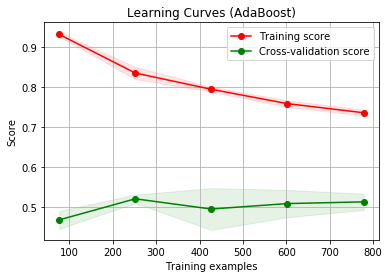

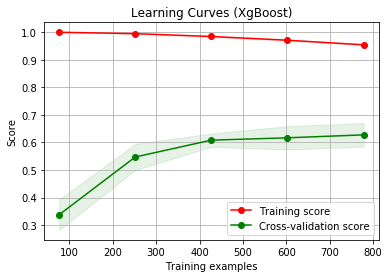

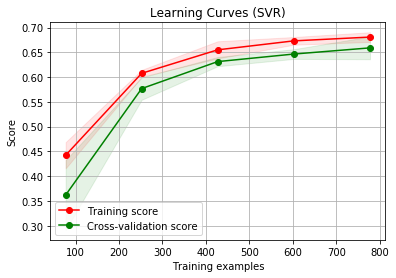

In [132]:
plot_learning_curve(estimator=adaBoost, title="Learning Curves (AdaBoost)", X=X_train_pca, y=y_train, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(estimator=xgb, title="Learning Curves (XgBoost)", X=X_train_pca, y=y_train, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(estimator=svr_model, title="Learning Curves (SVR)", X=X_train_pca, y=y_train, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

## Scatter Plots

In [55]:
def plotScatter(predicted, name):
    colors = ["r", "b"]
    plt.title(name + " Predicted vs Actual Sale Price")
    plt.xlabel("Actual Sale Price")
    plt.ylabel("Predicted Sale Price")
    red_patch = mpatches.Patch(color='red', label='Actual Sale Price')
    blue_patch = mpatches.Patch(color='blue', label='Predicted Sale Price')
    plt.legend(handles=[red_patch, blue_patch])
    plt.scatter(predicted['SalePrice'], predicted['predicted'], color=colors, alpha=0.5)
    plt.show()

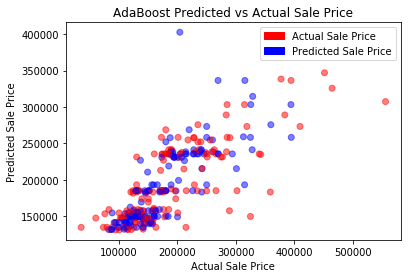

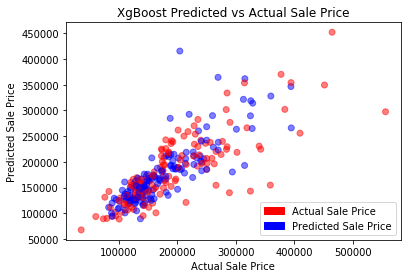

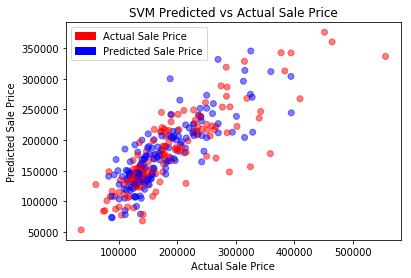

In [56]:
plotScatter(ada_pred, "AdaBoost")
plotScatter(xgb_pred, "XgBoost")
plotScatter(svr_pred, "SVM")

## Parameter Tuning

In [57]:
def plot_param_tuning(xgb_params, adaboost_params, svm_params):
    plt.plot(adaboost_params['parameter'], adaboost_params['rmse'], marker='o', color='b')
    plt.title("Adaboost RMSE vs n_estimators")
    plt.xlabel("n_estimators")
    plt.ylabel("RMSE")
    plt.show()
    
    plt.plot(xgb_params['parameter'], xgb_params['rmse'], marker='o', color='b')
    plt.title("XgBoost RMSE vs n_estimators")
    plt.xlabel("n_estimators")
    plt.ylabel("RMSE")
    plt.show()
    
    plt.plot(svm_params['parameter'], svm_params['rmse'], marker='o', color='b')
    plt.title("SVM RMSE vs C")
    plt.xlabel("C")
    plt.ylabel("RMSE")
    plt.show()

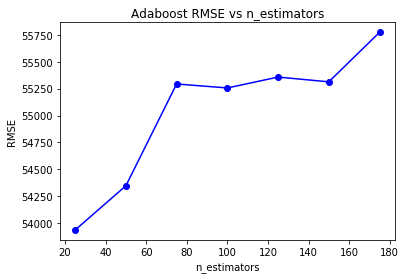

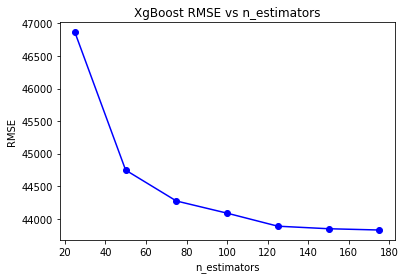

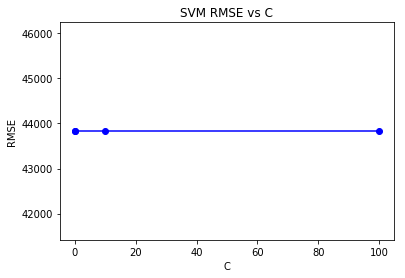

In [58]:
plot_param_tuning(xgb_params, adaboost_params, svm_params)